In [114]:
import numpy as np
import matplotlib.pyplot as plt

# The prysm stuff
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.propagation import Wavefront, focus_fixed_sampling
from prysm.geometry import circle,spider
from prysm.segmented import CompositeHexagonalAperture
from prysm import thinlens
from prysm.polynomials import (
    noll_to_nm,
    zernike_nm,
    zernike_nm_sequence,
    hopkins,
    sum_of_2d_modes
)

np.random.seed(20240820)

In [115]:
# USER INPUT HERE
# IC = Instrument Configuration
IC = {
    'image_dx' : 4.87, # um
    'pupil_diameter' : 10950, # mm
    'focal_length' : 338492, # mm
    'wavelength' : 0.94, # um
}
SEGMENTED_PUPIL = False

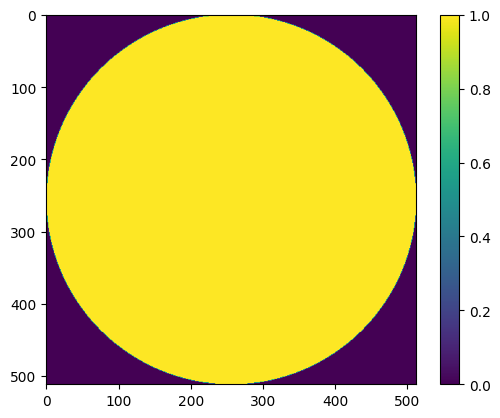

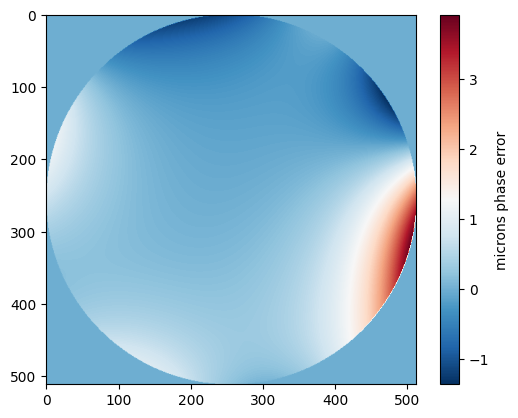

In [157]:
# optical system parameters
epd = IC['pupil_diameter'] # mm
efl = IC['focal_length'] # mm, Keck is F/13 I think
fno = efl / epd
wvl = IC['wavelength'] # um

# build the coordinate grids
x, y = make_xy_grid(128, diameter=epd)
r, t = cart_to_polar(x, y)
dx_p = x[0,1] - x[0,0]

if SEGMENTED_PUPIL:
    # make a keck-like pupil
    cha = CompositeHexagonalAperture(x, y, 3, 1.32e3, 0.007e3, exclude=(0,))

    # set up spiders
    m1 = spider(1, .1e3, x, y, rotation=-120)
    m2 = spider(1, .1e3, x, y, rotation=-60)
    m3 = spider(1, .1e3, x, y, rotation=90)
    spider_ = m1&m2&m3
    A = cha.amp & spider_

else:
    A = circle(epd / 2, r)

plt.figure()
plt.imshow(A)
plt.colorbar()
plt.show()

# construct a polynomial basis to generate wavefront error
r_z = r / (epd / 2) # normalized radius
nms = [noll_to_nm(j) for j in range(2, 37)]
coefs = np.random.random(len(nms))
basis = list(zernike_nm_sequence(nms, r, t, norm=True))
basis_norm = [b / np.max(np.abs(b)) for b in basis]
phs = sum_of_2d_modes(basis_norm, coefs) * 1
amp = A

plt.figure()
plt.imshow(phs * amp, cmap='RdBu_r')
plt.colorbar(label='microns phase error')
plt.show()

# Propagate to focus
# NOTE: Phase should be in nm, wvl should be in microns, dx_p should be in mm
# NOTE: WAVEFRONT AND FOCUS_FIXED_SAMPLING HAVE DIFFERENT NORMALIZATIONS AND THROW OFF THE ALGORITHM
k = 2 * np.pi / wvl # enforces phs in microns
wf = amp * np.exp(1j * k * phs)

def prop_to_focus(wavefunction, defocus_waves=0):

    # configure the defocus polynomial
    focus_polynomial = 2 * basis_norm[2] * defocus_waves
    defocus_aberration = amp * np.exp(-1j * 2 * np.pi * focus_polynomial)


    psf = focus_fixed_sampling(wavefunction=wavefunction * defocus_aberration,
                            input_dx=dx_p,
                            prop_dist=efl,
                            wavelength=wvl,
                            output_dx=IC['image_dx'],
                            output_samples=64)
    psf0 = np.abs(psf)**2
    return psf0

psf0 = prop_to_focus(wf, defocus_waves=0)
psf1 = prop_to_focus(wf, defocus_waves=1)
psf2 = prop_to_focus(wf, defocus_waves=2)
psf3 = prop_to_focus(wf, defocus_waves=3)

In [158]:
help(thinlens.defocus_to_image_displacement)

Help on function defocus_to_image_displacement in module prysm.thinlens:

defocus_to_image_displacement(W020, fno, wavelength=None)
    Compute image displacment from wavefront defocus expressed in waves 0-P to.
    
    Parameters
    ----------
    W020 : float or numpy.ndarray
        wavefront defocus, units of waves if wavelength != None, else units of length
    fno : float
        f/# of the lens or system
    wavelength : float, optional
        wavelength of light, if None W020 takes units of length
    
    Returns
    -------
    float
        image displacement.  Motion of image in um caused by defocus OPD



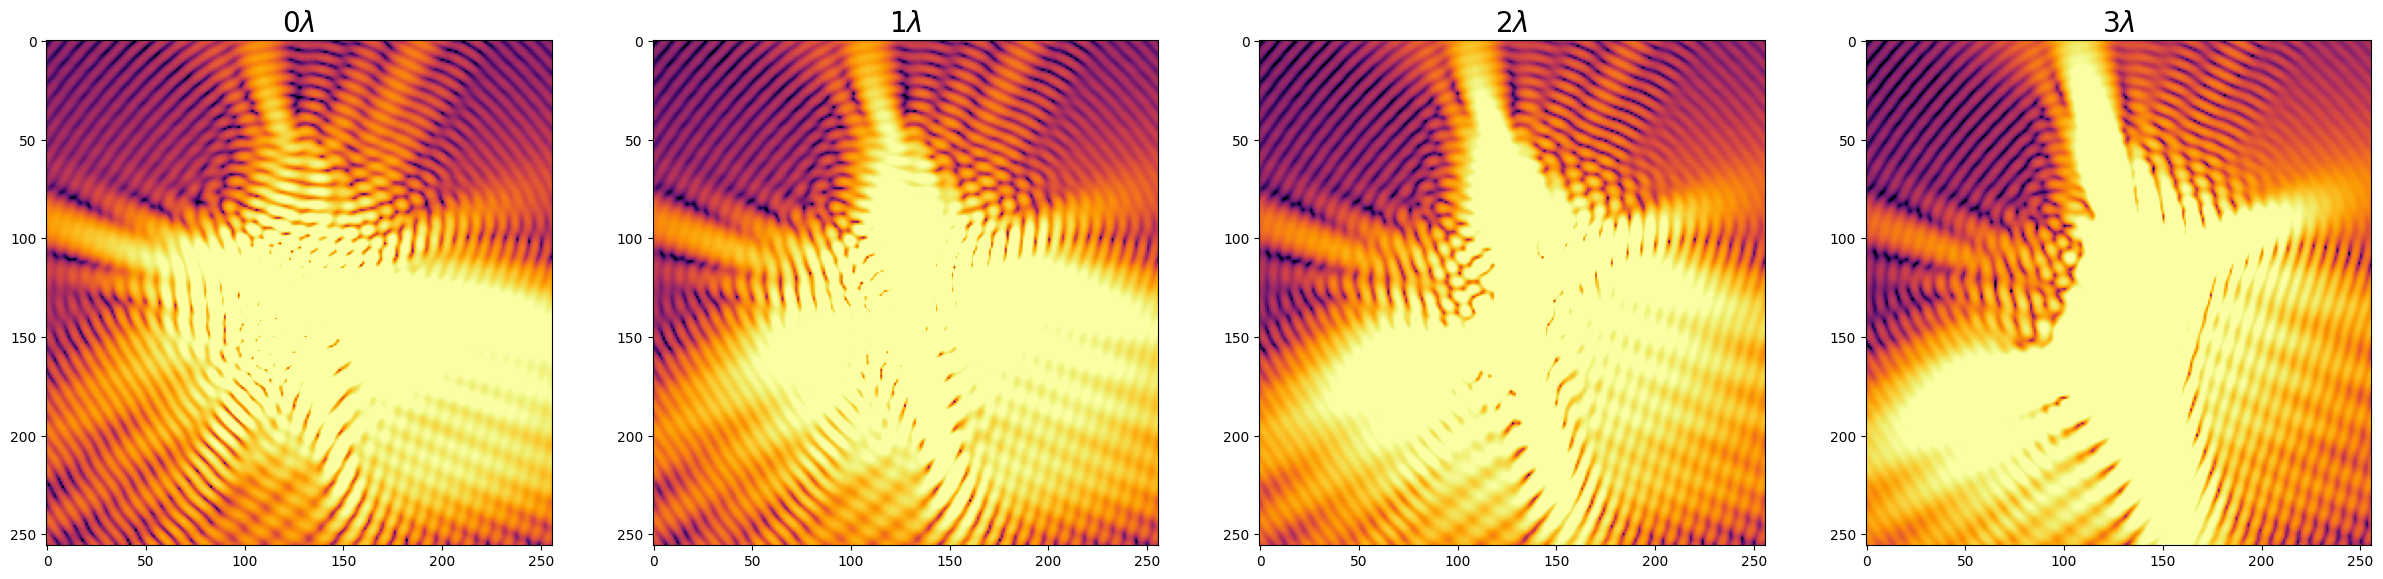

In [159]:
psflist = [psf0, psf1, psf2, psf3]
titles = [f'{i}'+r'$\lambda$' for i in range(0,4)]
fig,axs = plt.subplots(ncols=len(psflist),figsize=[30,10])
for _psf,ax,title in zip(psflist,axs,titles):
    ax.set_title(title,fontsize=20)
    # _psf /= np.max(_psf)
    ax.imshow(np.log10((_psf)),cmap='inferno',vmax=0,vmin=-4)
plt.show()

In [160]:
import poi
# adpr = poi.ADPhaseRetrieval(amp, psf0, IC, basis_norm, defocus=0)
adpr = poi.VAPPOptimizer2(amp, dx_p, efl, wvl, basis_norm, psflist[0], IC['image_dx'])

In [161]:
adpr.fwd(np.zeros(len(coefs)))

404472191.2595837

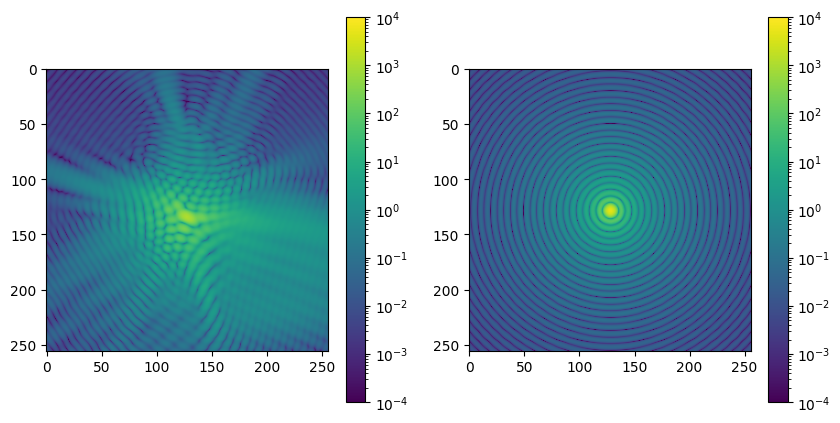

In [162]:
from matplotlib.colors import LogNorm
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.imshow(adpr.D, norm=LogNorm(vmin=1e-4,vmax=1e4))
plt.colorbar()
plt.subplot(122)
plt.imshow(adpr.I, norm=LogNorm(vmin=1e-4,vmax=1e4))
plt.colorbar()
plt.show()


In [163]:
from scipy.optimize import minimize
results = minimize(adpr.fg, x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-20, 'gtol': 1e-20, 'maxiter': 200, 'disp': 1})

In [164]:
print(results)

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 4631.127675531554
        x: [ 1.450e-01  3.575e-01 ...  1.828e-02  8.569e-01]
      nit: 200
      jac: [ 5.460e+03  8.688e+03 ... -1.129e+04 -2.566e+03]
     nfev: 237
     njev: 237
 hess_inv: <35x35 LbfgsInvHessProduct with dtype=float64>


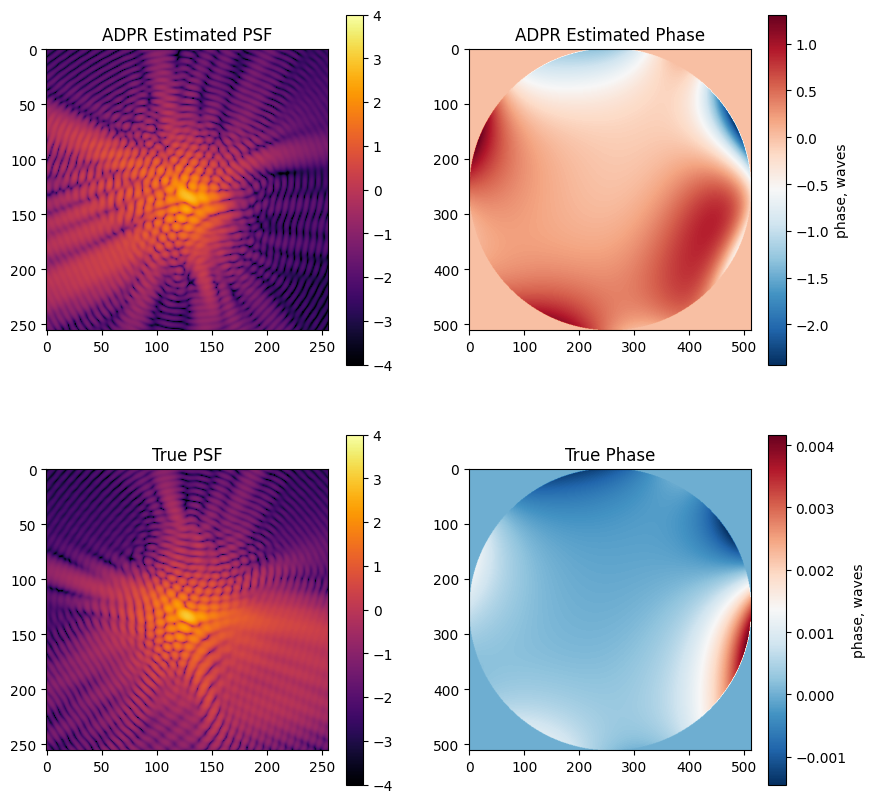

In [173]:
test_vector = np.zeros_like(coefs)
test_vector[2] = 2
k = 2 * np.pi / wvl
E = adpr.fwd(results.x)

plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('ADPR Estimated PSF')
plt.imshow(np.log10(adpr.I), cmap='inferno', vmax=4, vmin=-4)
plt.colorbar()
plt.subplot(222)
plt.title('ADPR Estimated Phase')
plt.imshow(adpr.W * amp / k, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.subplot(223)
plt.title('True PSF')
plt.imshow(np.log10(adpr.D), cmap='inferno', vmax=4, vmin=-4)
plt.colorbar()
plt.subplot(224)
plt.title('True Phase')
plt.imshow(phs * amp / (wvl * 1e3), cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.show()

In [174]:
adpr1 = poi.VAPPOptimizer2(amp, dx_p, efl, wvl, basis_norm, psflist[1], IC['image_dx'], defocus_waves=1)

In [175]:
results = minimize(adpr1.fg,
                   x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-17, 'gtol': 1e-17, 'maxiter': 200, 'disp': 0})

C:\Users\Work\AppData\Local\Temp\ipykernel_10472\3408301021.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(phase_est / amp, cmap='RdBu_r')
C:\Users\Work\AppData\Local\Temp\ipykernel_10472\3408301021.py:28: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(phase_truth / amp, cmap='RdBu_r')


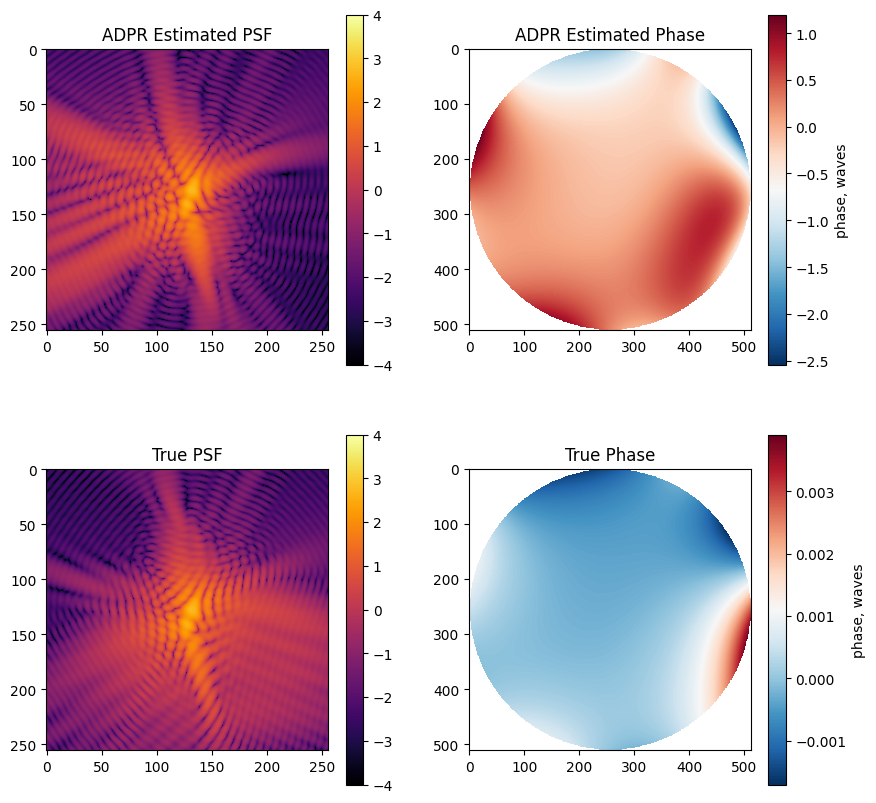

In [177]:
test_vector = np.zeros_like(coefs)
test_vector[2] = 0
k = 2 * np.pi / wvl
E = adpr.fwd(results.x)

phase_est = adpr1.phs
phase_est -= np.mean(phase_est[amp==1])

phase_truth = phs / (wvl * 1e3)
phase_truth -= np.mean(phase_truth[amp==1])


plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('ADPR Estimated PSF')
plt.imshow(np.log10(adpr1.I), cmap='inferno', vmax=4, vmin=-4)
plt.colorbar()
plt.subplot(222)
plt.title('ADPR Estimated Phase')
plt.imshow(phase_est / amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.subplot(223)
plt.title('True PSF')
plt.imshow(np.log10(adpr1.D), cmap='inferno', vmax=4, vmin=-4)
plt.colorbar()
plt.subplot(224)
plt.title('True Phase')
plt.imshow(phase_truth / amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.show()

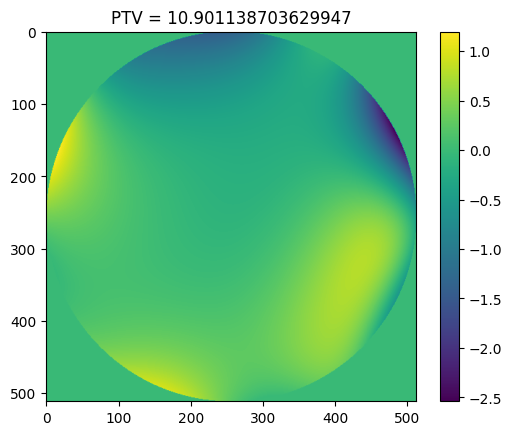

In [178]:
phase_diff = phase_est - phase_truth
plt.figure()
plt.title(f'PTV = {phase_diff.max() - phase_diff.min()}')
plt.imshow(phase_diff * amp)
plt.colorbar()
# 1.4, 1
# 0.78, 2
# 3. 0.35
# 0.639, 4, flipped sign

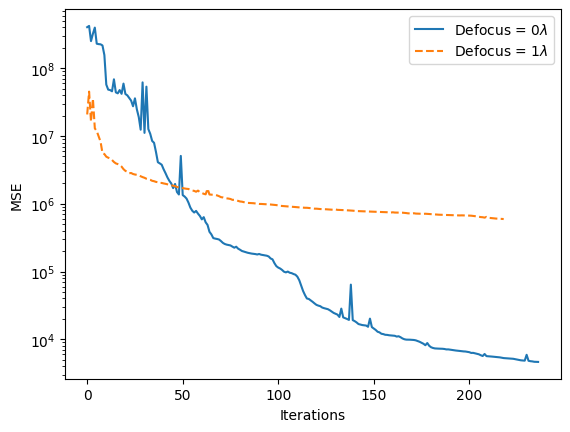

In [179]:
plt.plot()
plt.plot(adpr.cost, label='Defocus = '+r'$0\lambda$')
plt.plot(adpr1.cost, label='Defocus = '+r'$1\lambda$', linestyle='dashed')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.yscale('log')
plt.show()

# And now we try focus diversity

In [181]:
# configure the individual optimizers
adpr0 = poi.VAPPOptimizer2(amp, dx_p, efl, wvl, basis_norm, psflist[0], IC['image_dx'], defocus_waves=0)
adpr1 = poi.VAPPOptimizer2(amp, dx_p, efl, wvl, basis_norm, psflist[1], IC['image_dx'], defocus_waves=1)

# set up the net optimizer
optlist = [adpr0, adpr1]
fdpr = poi.ParallelADPhaseRetrieval(optlist)

In [183]:
results = minimize(fdpr.fg,
                   x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-17, 'gtol': 1e-17, 'maxiter': 200, 'disp': 0})

In [184]:
print(results)

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 8528.982988097261
        x: [ 1.297e-01  3.522e-01 ...  1.297e-01  8.363e-01]
      nit: 200
      jac: [-4.562e+04  7.683e+04 ...  1.338e+04  2.578e+03]
     nfev: 228
     njev: 228
 hess_inv: <35x35 LbfgsInvHessProduct with dtype=float64>


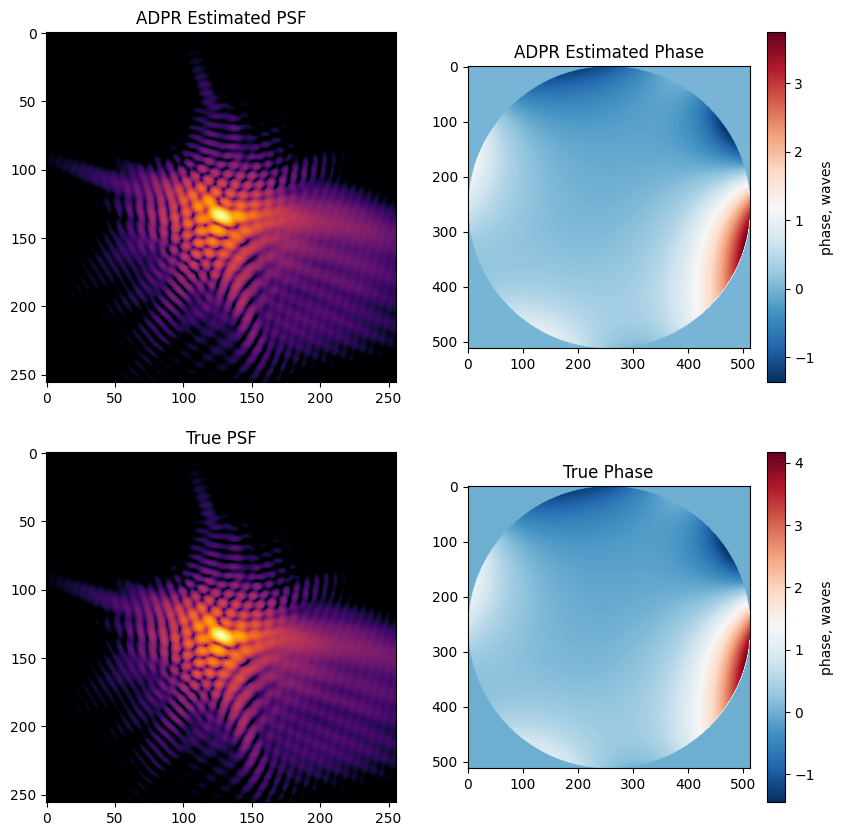

In [186]:
k = 2 * np.pi / wvl

psf_est = fdpr.optlist[0].I
psf_est /= psf_est.max()
psf_truth = fdpr.optlist[0].D
psf_truth /= psf_truth.max()

phase_est = sum_of_2d_modes(basis_norm, results.x)
phase_truth = phs / (wvl)


plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('ADPR Estimated PSF')
plt.imshow(np.log10(psf_est), cmap='inferno', vmax=0, vmin=-4)
plt.subplot(222)
plt.title('ADPR Estimated Phase')
plt.imshow(phase_est * amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.subplot(223)
plt.title('True PSF')
plt.imshow(np.log10(psf_truth), cmap='inferno', vmax=0, vmin=-4)
plt.subplot(224)
plt.title('True Phase')
plt.imshow(phase_truth * amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.show()

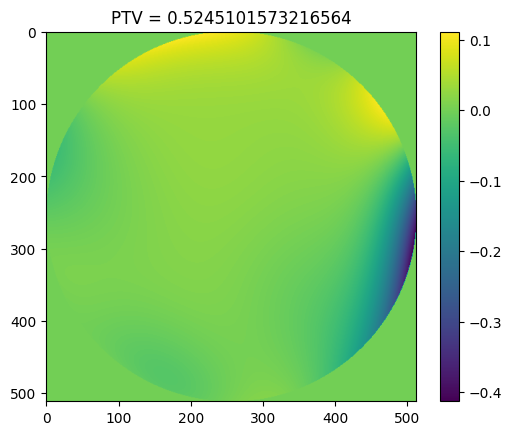

In [187]:
phase_diff = phase_est - phase_truth
phase_diff -= np.mean(phase_diff[amp==1])
plt.figure()
plt.title(f'PTV = {phase_diff[amp==1].max() - phase_diff[amp==1].min()}')
plt.imshow(phase_diff * amp)
plt.colorbar()

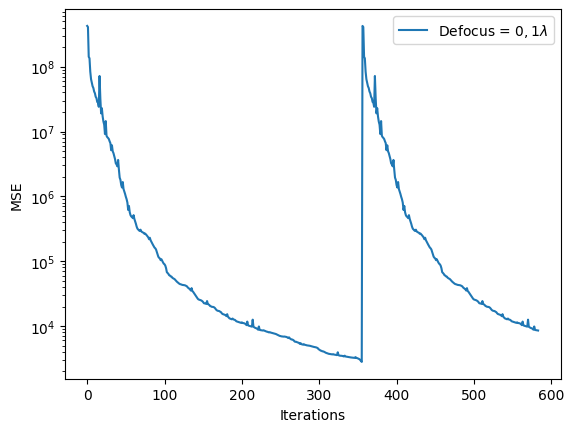

In [188]:
plt.plot()
plt.plot(fdpr.cost, label='Defocus = '+r'$0, 1\lambda$')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.yscale('log')
plt.show()